In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import inf
import scipy
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from scipy.stats import ttest_ind
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

In [2]:
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'diabetes'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

diabetes_df = pd.read_sql_query('select * from diabetes',con=engine)

engine.dispose()

In [3]:
diabetes_df.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age,outcome
0,5,44,62,0,0,25.0,0.587,36,0
1,2,56,56,28,45,24.2,0.332,22,0
2,9,57,80,37,0,32.8,0.096,41,0
3,0,57,60,0,0,21.7,0.735,67,0
4,3,61,82,28,0,34.4,0.243,46,0


In [4]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763 entries, 0 to 762
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pregnancies        763 non-null    int64  
 1   glucose            763 non-null    int64  
 2   blood_pressure     763 non-null    int64  
 3   skin_thickness     763 non-null    int64  
 4   insulin            763 non-null    int64  
 5   bmi                763 non-null    float64
 6   diabetes_pedigree  763 non-null    float64
 7   age                763 non-null    int64  
 8   outcome            763 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 53.8 KB


In [5]:
diabetes_df.isnull().sum()

pregnancies          0
glucose              0
blood_pressure       0
skin_thickness       0
insulin              0
bmi                  0
diabetes_pedigree    0
age                  0
outcome              0
dtype: int64

In [6]:
diabetes_df.duplicated().sum()

0

In [7]:
diabetes_df.describe()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age,outcome
count,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000,763.000000
mean,3.851900,121.686763,69.115334,20.477064,80.292267,31.986763,0.472477,33.271298,0.348624
std,3.374729,30.535641,19.399240,15.973171,115.457448,7.893221,0.331963,11.772161,0.476847
min,0.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243500,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,36.000000,32.000000,0.374000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,128.500000,36.550000,0.626500,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


The zero values in glucose, blood_pressure, and skin_thickness are biological factors which can't be 0. I will replace them with NaN.
An insulin level of 0 can be had for people with untreated type 1 however the large number of zero values in the dataset implies they are NaN.

In [8]:
diabetes_df[['glucose', 'blood_pressure', 'skin_thickness', 'bmi', 'insulin']] = diabetes_df[['glucose', 'blood_pressure', 'skin_thickness', 'bmi', 'insulin']].replace(0,np.NaN)

In [9]:
diabetes_df.isnull().sum()

pregnancies            0
glucose                0
blood_pressure        35
skin_thickness       227
insulin              370
bmi                   11
diabetes_pedigree      0
age                    0
outcome                0
dtype: int64

Due to the high number of NaN observations in the variables skin_thickness & insulin 
I find the prudent choice is to drop the NaN's. Filling that many with the median or mean could bias the data.

In [10]:
diabetes_df.dropna(inplace=True)

In [11]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 1 to 761
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pregnancies        392 non-null    int64  
 1   glucose            392 non-null    int64  
 2   blood_pressure     392 non-null    float64
 3   skin_thickness     392 non-null    float64
 4   insulin            392 non-null    float64
 5   bmi                392 non-null    float64
 6   diabetes_pedigree  392 non-null    float64
 7   age                392 non-null    int64  
 8   outcome            392 non-null    int64  
dtypes: float64(5), int64(4)
memory usage: 30.6 KB


array([[<AxesSubplot:title={'center':'pregnancies'}>,
        <AxesSubplot:title={'center':'glucose'}>,
        <AxesSubplot:title={'center':'blood_pressure'}>],
       [<AxesSubplot:title={'center':'skin_thickness'}>,
        <AxesSubplot:title={'center':'insulin'}>,
        <AxesSubplot:title={'center':'bmi'}>],
       [<AxesSubplot:title={'center':'diabetes_pedigree'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'outcome'}>]], dtype=object)

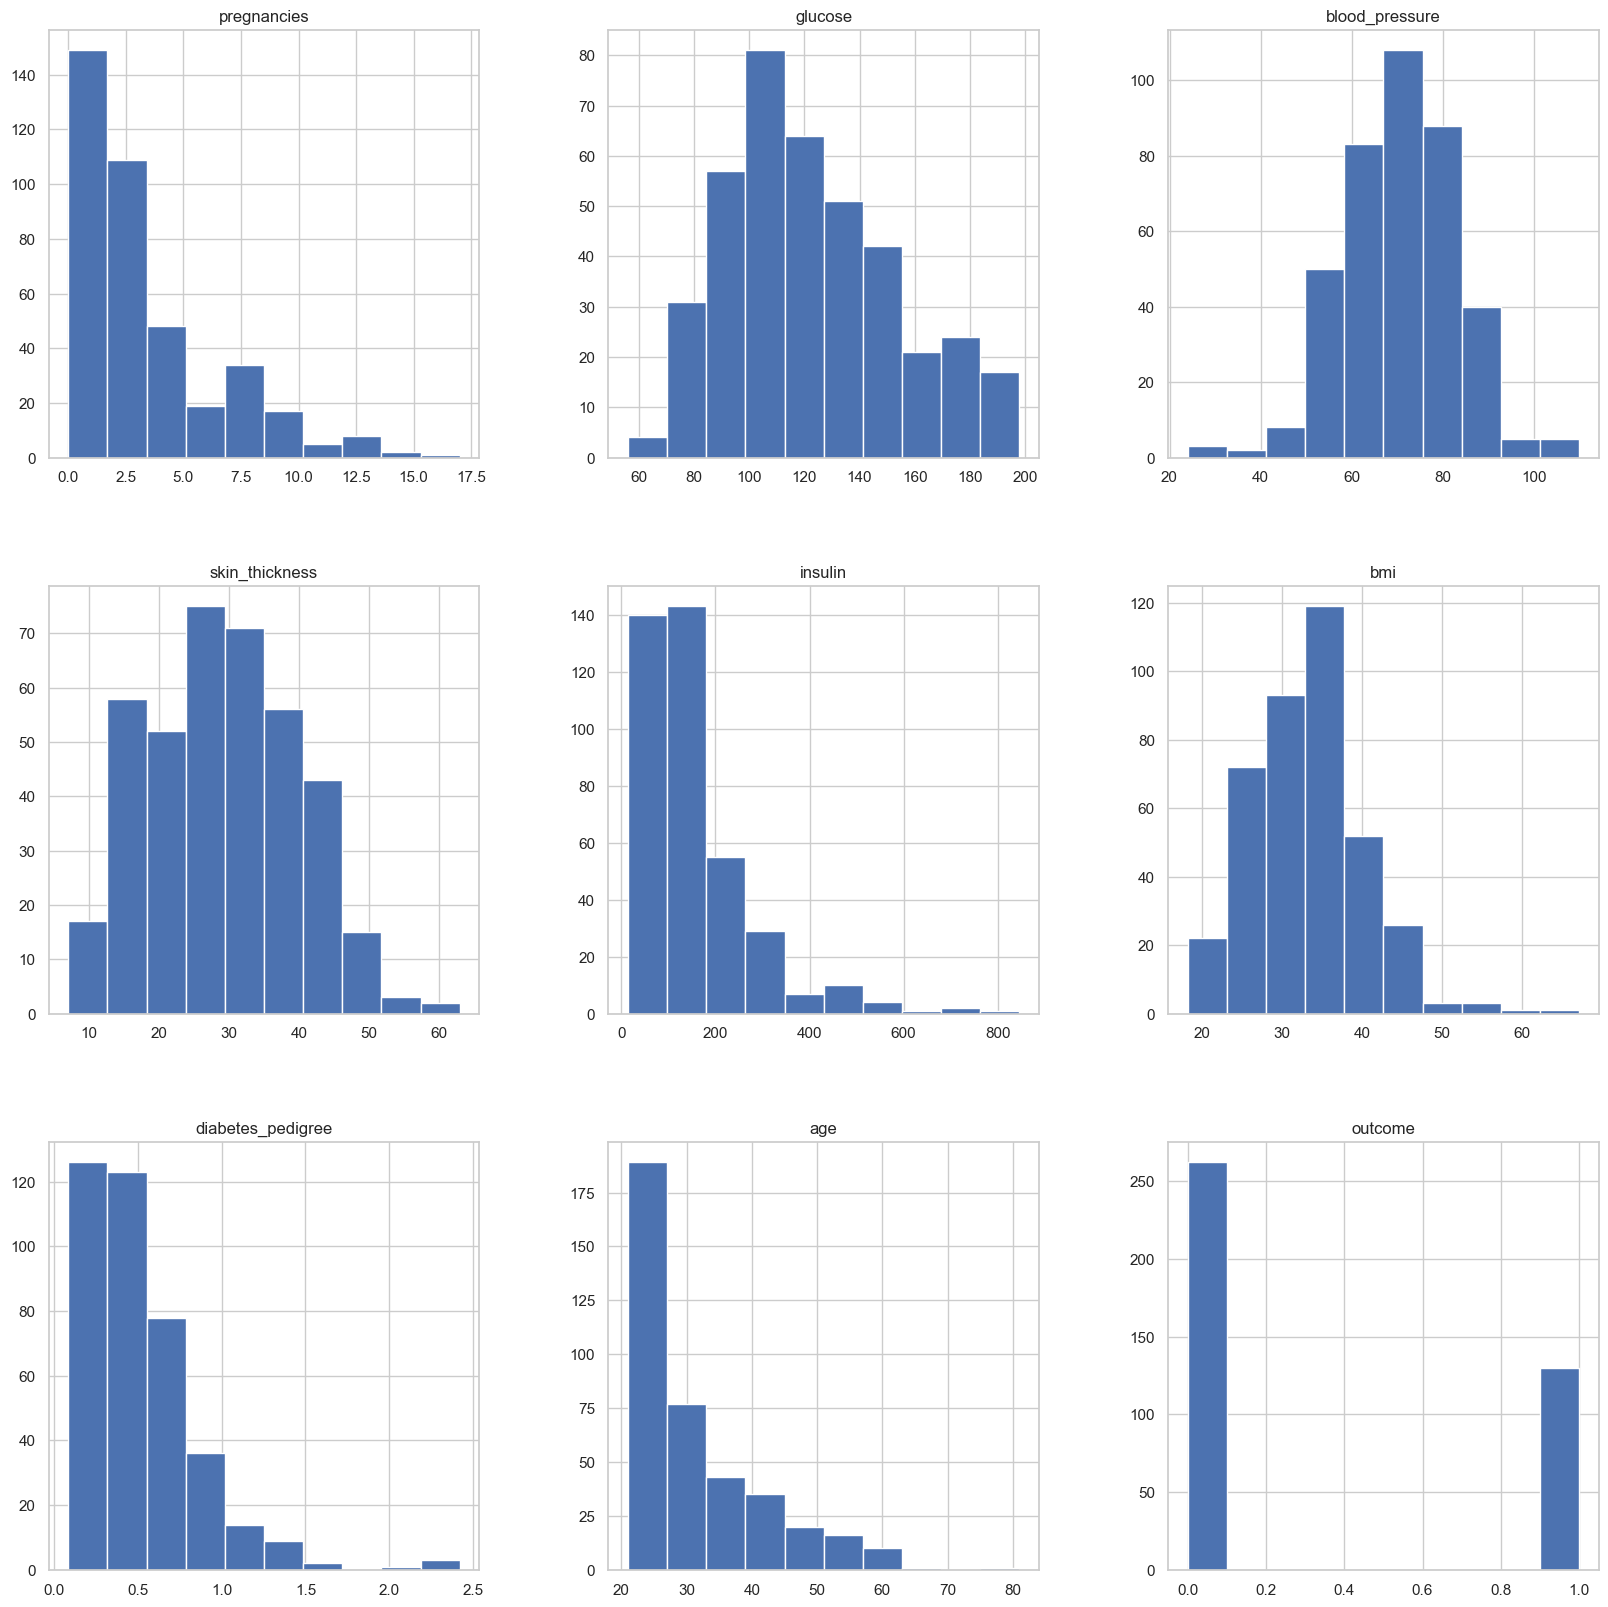

In [12]:
diabetes_df.hist(figsize = (20,20))

In [13]:
jb_stats = jarque_bera(diabetes_df["pregnancies"])
norm_stats = normaltest(diabetes_df["pregnancies"])

print("pregnancies Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("pregnancies Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(diabetes_df["glucose"])
norm_stats = normaltest(diabetes_df["glucose"])

print("glucose Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("glucose Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(diabetes_df["blood_pressure"])
norm_stats = normaltest(diabetes_df["blood_pressure"])

print("blood_pressure Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("blood_pressure Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(diabetes_df["skin_thickness"])
norm_stats = normaltest(diabetes_df["skin_thickness"])

print("skin_thickness Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("skin_thickness Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(diabetes_df["insulin"])
norm_stats = normaltest(diabetes_df["insulin"])

print("insulin Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("insulin Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(diabetes_df["bmi"])
norm_stats = normaltest(diabetes_df["bmi"])

print("bmi Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("bmi Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(diabetes_df["diabetes_pedigree"])
norm_stats = normaltest(diabetes_df["diabetes_pedigree"])

print("diabetes_pedigree Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("diabetes_pedigree Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(diabetes_df["age"])
norm_stats = normaltest(diabetes_df["age"])

print("age Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("age Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

pregnancies Jarque-Bera test statistics is 150.09593437585687 and p value is 2.5531831654682644e-33
pregnancies Normality test statistics is 88.46884241137282 and p value is 6.155097831782508e-20
glucose Jarque-Bera test statistics is 21.34575520189099 and p value is 2.3164778500807602e-05
glucose Normality test statistics is 22.45882106271417 and p value is 1.3277887088487214e-05
blood_pressure Jarque-Bera test statistics is 10.181306408877424 and p value is 0.00615399875469869
blood_pressure Normality test statistics is 7.002151429612247 and p value is 0.030164917115239272
skin_thickness Jarque-Bera test statistics is 6.404782470350045 and p value is 0.04066484840882286
skin_thickness Normality test statistics is 8.33598271873159 and p value is 0.01548332935449814
insulin Jarque-Bera test statistics is 944.0790073206076 and p value is 9.904859511636796e-206
insulin Normality test statistics is 193.66209966353955 and p value is 8.8472720359224e-43
bmi Jarque-Bera test statistics is 66

None of the indicators are normally distributed.

Checking for outliers

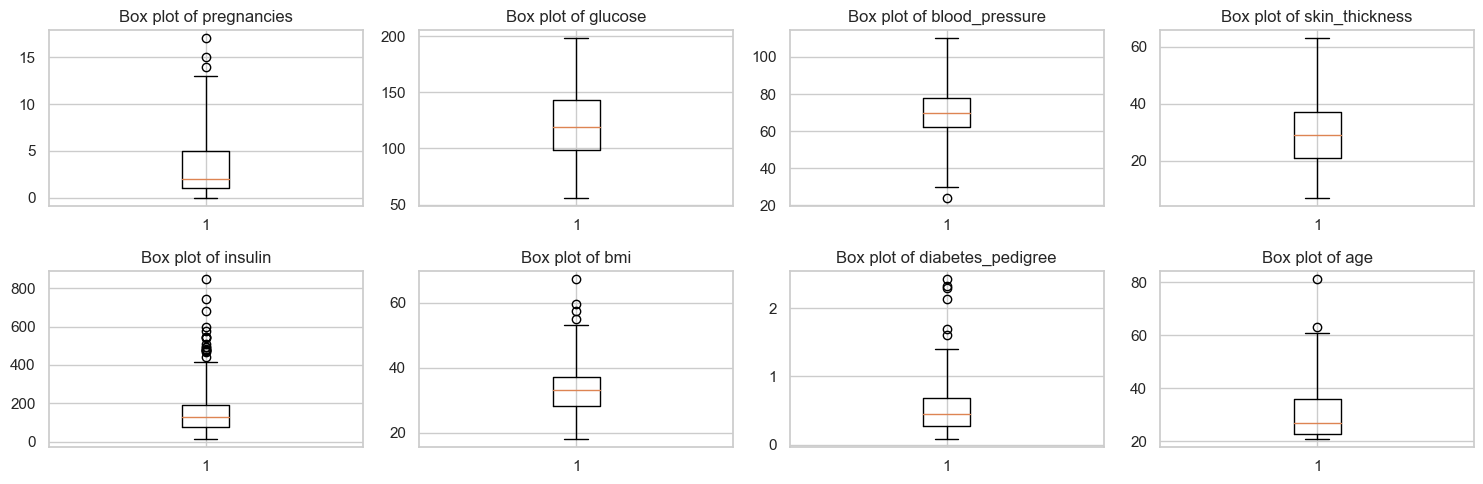

In [14]:
plt.figure(figsize = (15,5))

plt.subplot(2,4,1)
plt.boxplot(diabetes_df["pregnancies"], whis = 2)
plt.title("Box plot of pregnancies")

plt.subplot(2,4,2)
plt.boxplot(diabetes_df["glucose"], whis = 2)
plt.title("Box plot of glucose")

plt.subplot(2,4,3)
plt.boxplot(diabetes_df["blood_pressure"], whis = 2)
plt.title("Box plot of blood_pressure")

plt.subplot(2,4,4)
plt.boxplot(diabetes_df["skin_thickness"], whis = 2)
plt.title("Box plot of skin_thickness")

plt.subplot(2,4,5)
plt.boxplot(diabetes_df["insulin"], whis = 2)
plt.title("Box plot of insulin")

plt.subplot(2,4,6)
plt.boxplot(diabetes_df["bmi"], whis = 2)
plt.title("Box plot of bmi")

plt.subplot(2,4,7)
plt.boxplot(diabetes_df["diabetes_pedigree"], whis = 2)
plt.title("Box plot of diabetes_pedigree")

plt.subplot(2,4,8)
plt.boxplot(diabetes_df["age"], whis = 2)
plt.title("Box plot of age")

plt.tight_layout()
plt.show()

In [15]:
list_of_columns = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree', 'age']

In [16]:
for col in list_of_columns:
    q75, q25 = np.percentile(diabetes_df[col], [75 ,25])
    iqr = q75 - q25


    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)

    print("Number of outliers for {} is: {} and it is {} percent.".format(col, len((np.where((diabetes_df[col] > max_val) 
                      | (diabetes_df[col] < min_val))[0])), len((np.where((diabetes_df[col] > max_val) | 
                                                    (diabetes_df[col] < min_val))[0]))*100/392))

Number of outliers for pregnancies is: 11 and it is 2.806122448979592 percent.
Number of outliers for glucose is: 0 and it is 0.0 percent.
Number of outliers for blood_pressure is: 7 and it is 1.7857142857142858 percent.
Number of outliers for skin_thickness is: 1 and it is 0.25510204081632654 percent.
Number of outliers for insulin is: 25 and it is 6.377551020408164 percent.
Number of outliers for bmi is: 6 and it is 1.530612244897959 percent.
Number of outliers for diabetes_pedigree is: 12 and it is 3.061224489795918 percent.
Number of outliers for age is: 13 and it is 3.316326530612245 percent.


Due to the relatively low number of outliers and the chance that removing biological data may bias the results
I will not remove them.

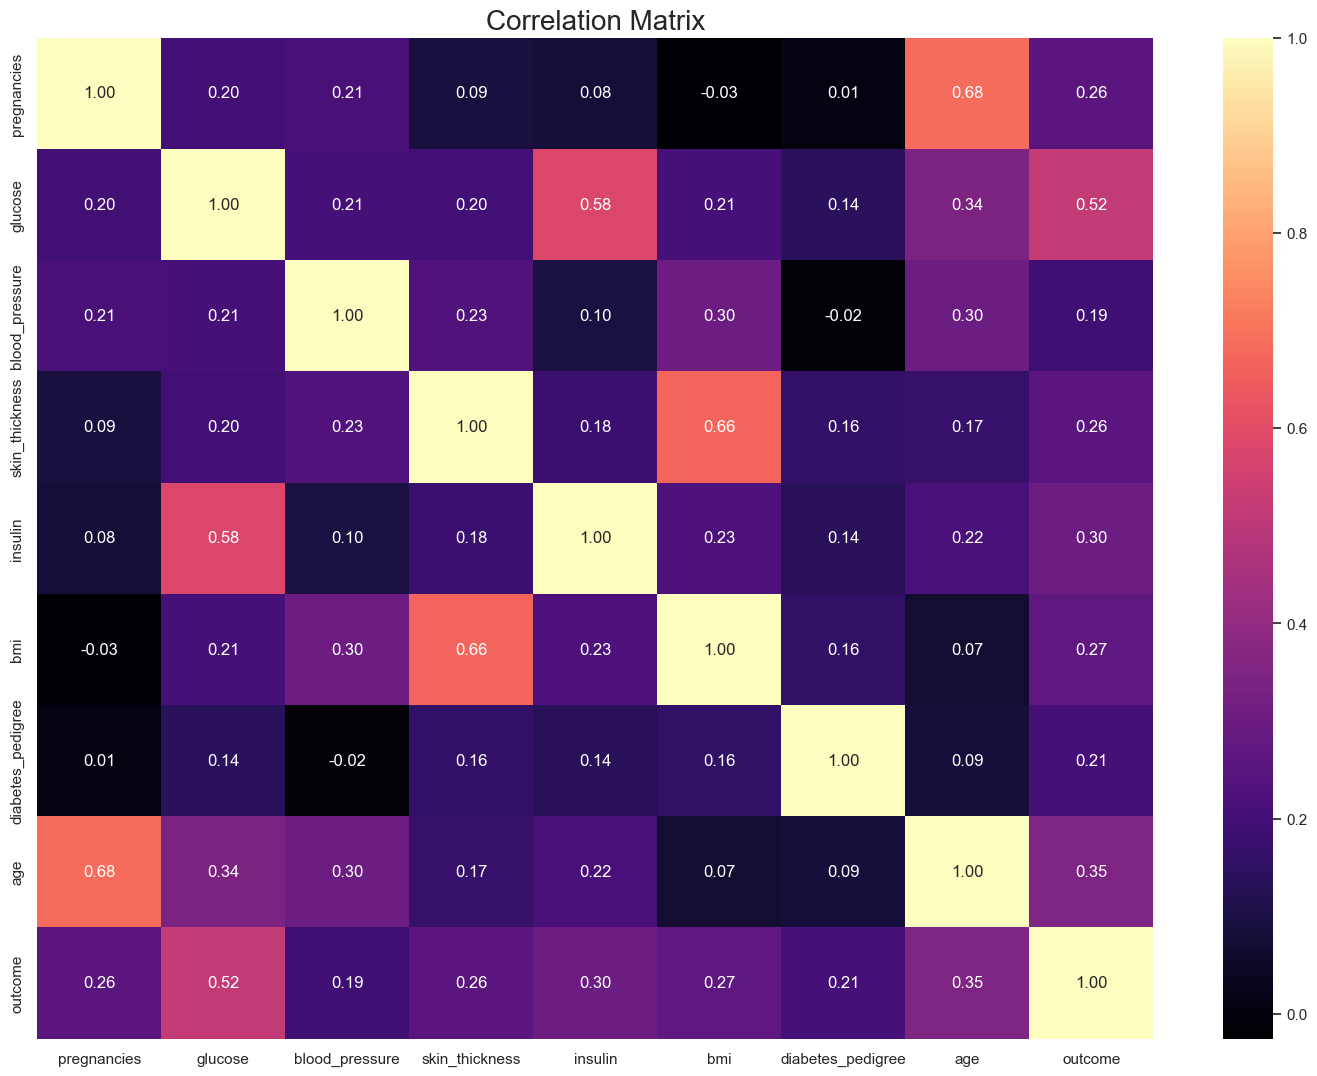

In [17]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(diabetes_df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [18]:
diabetes_df.corr()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age,outcome
pregnancies,1.000000,0.198291,0.213355,0.093209,0.078984,-0.025347,0.007562,0.679608,0.256566
glucose,0.198291,1.000000,0.210027,0.198856,0.581223,0.209516,0.140180,0.343641,0.515703
blood_pressure,0.213355,0.210027,1.000000,0.232571,0.098512,0.304403,-0.015971,0.300039,0.192673
skin_thickness,0.093209,0.198856,0.232571,1.000000,0.182199,0.664355,0.160499,0.167761,0.255936
insulin,0.078984,0.581223,0.098512,0.182199,1.000000,0.226397,0.135906,0.217082,0.301429
bmi,-0.025347,0.209516,0.304403,0.664355,0.226397,1.000000,0.158771,0.069814,0.270118
diabetes_pedigree,0.007562,0.140180,-0.015971,0.160499,0.135906,0.158771,1.000000,0.085029,0.209330
age,0.679608,0.343641,0.300039,0.167761,0.217082,0.069814,0.085029,1.000000,0.350804
outcome,0.256566,0.515703,0.192673,0.255936,0.301429,0.270118,0.209330,0.350804,1.000000


All variables have a positive correlation with the target variable (outcome).

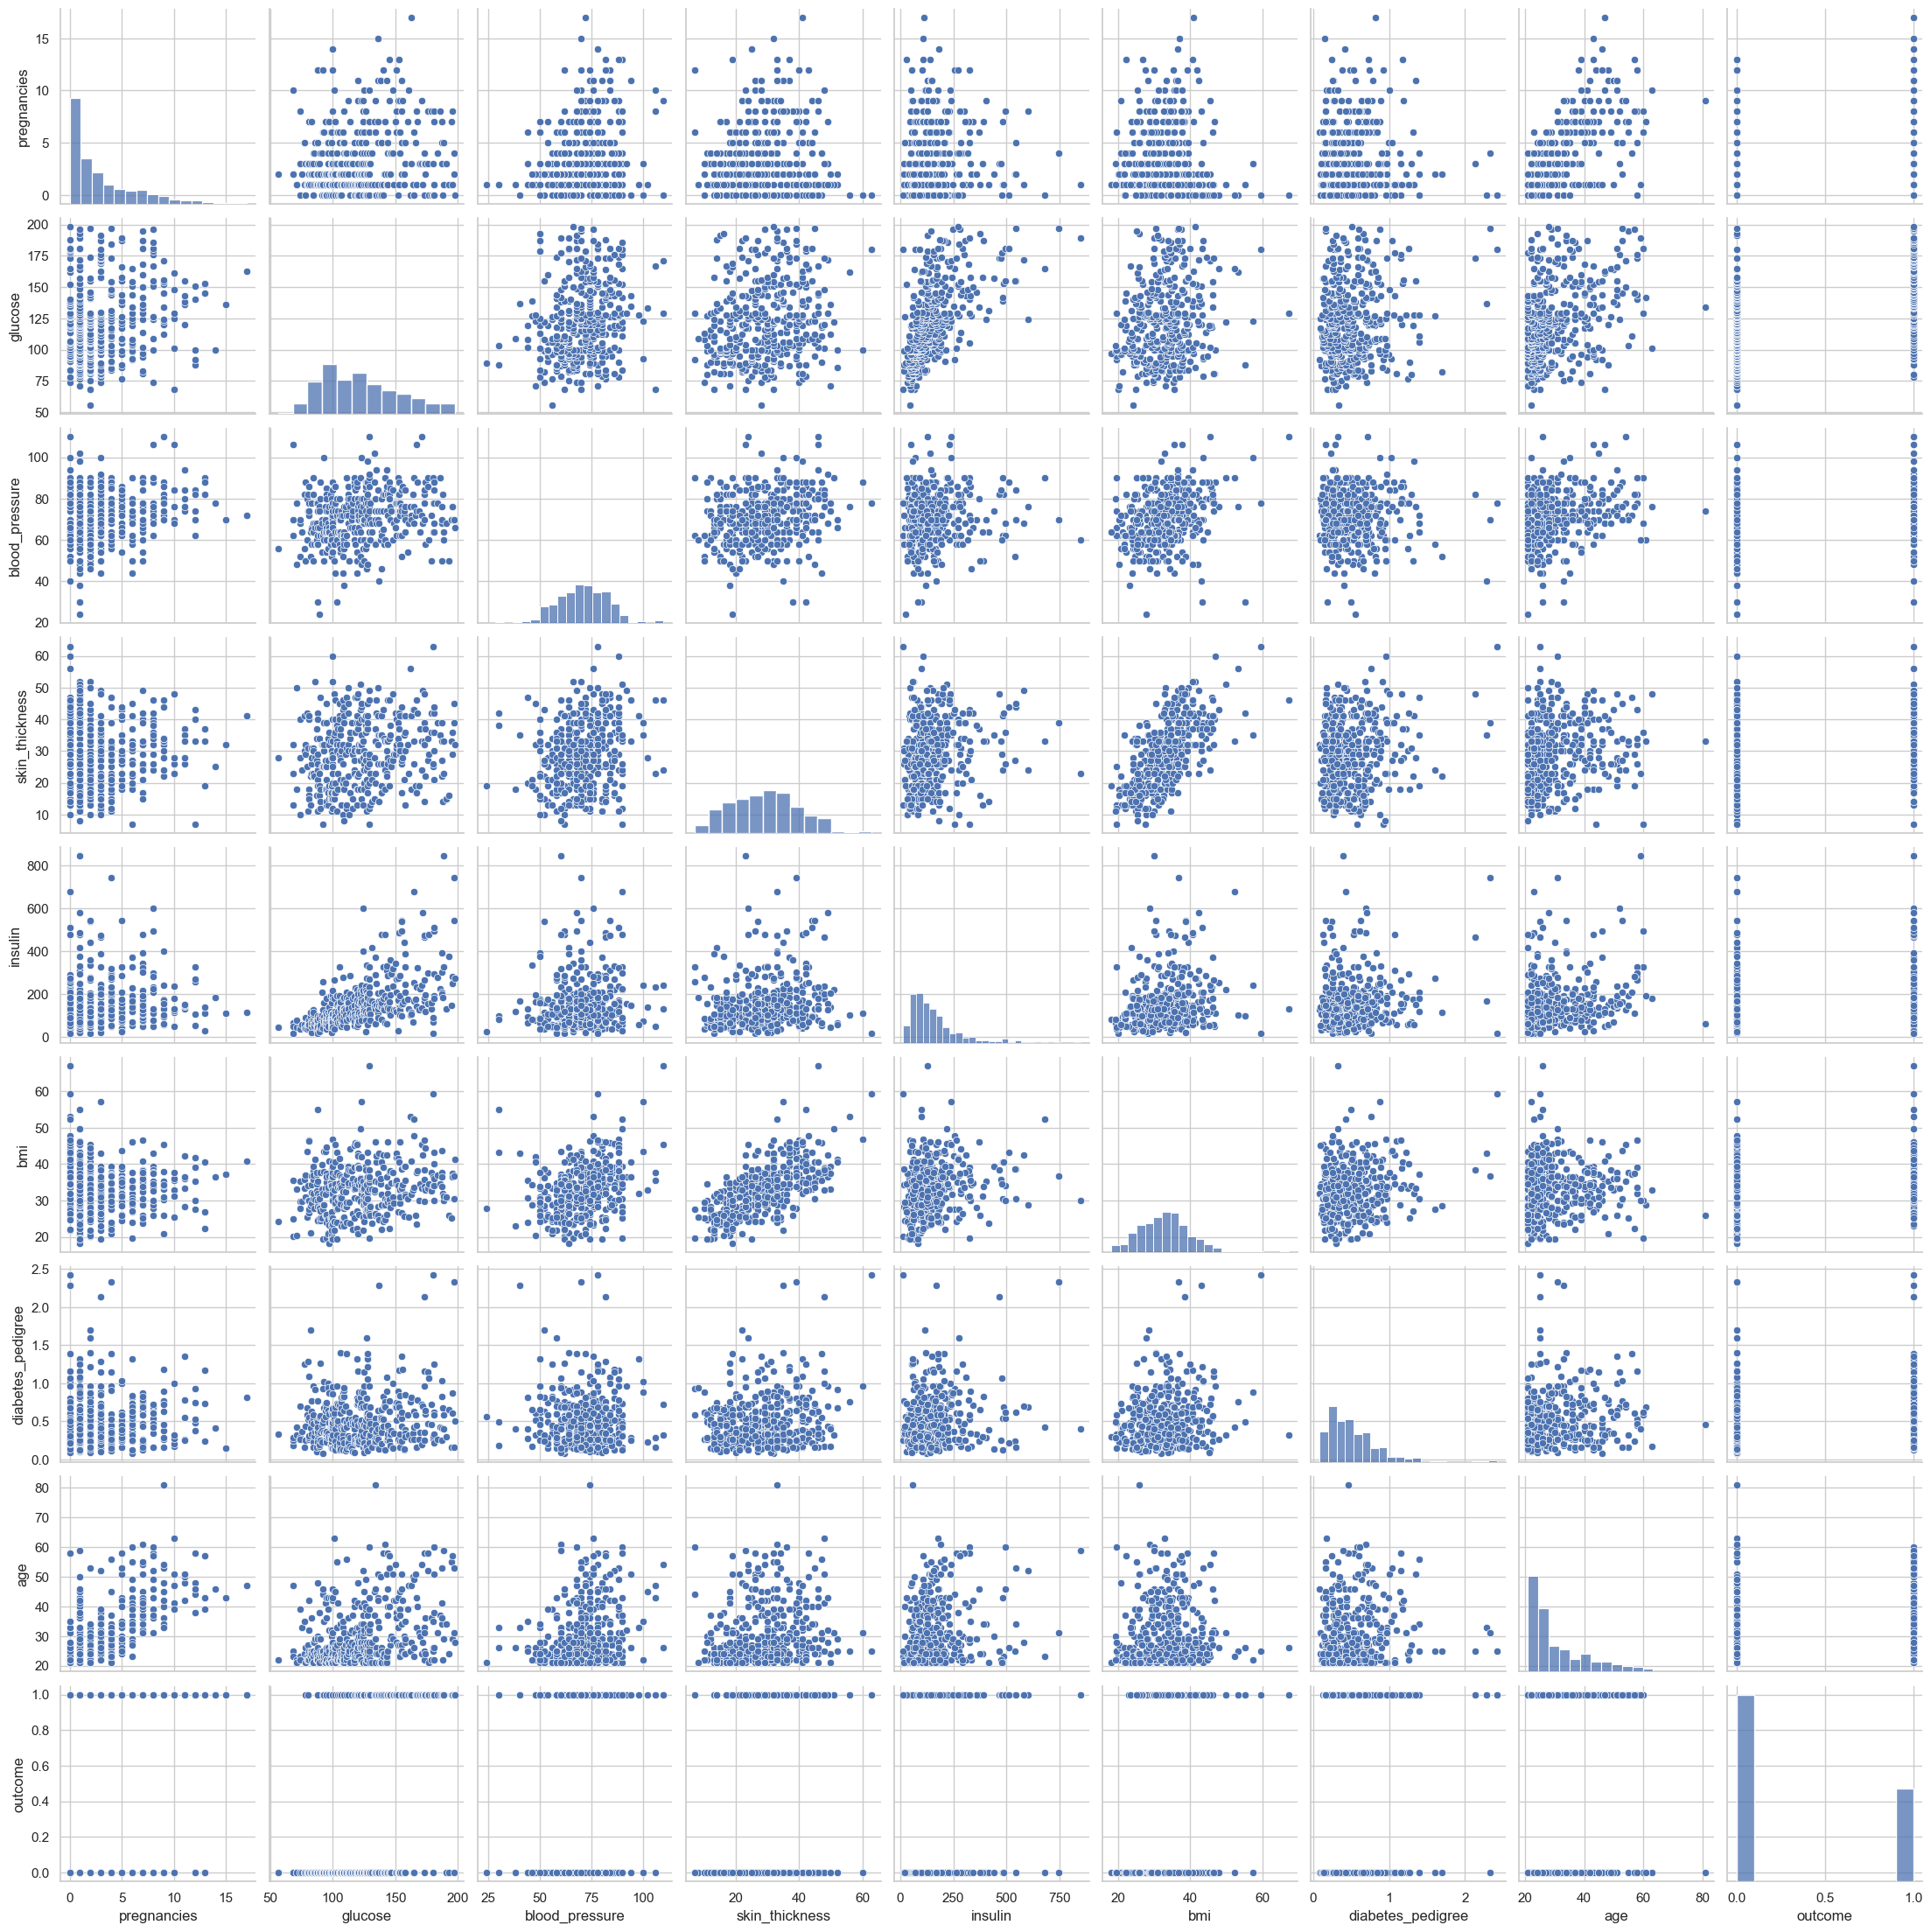

In [19]:
myplot = sns.pairplot(diabetes_df)

In [20]:
diabetes_df.groupby('outcome').count()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age
outcome,,,,,,,,
0,262,262,262,262,262,262,262,262
1,130,130,130,130,130,130,130,130


<AxesSubplot:xlabel='outcome', ylabel='count'>

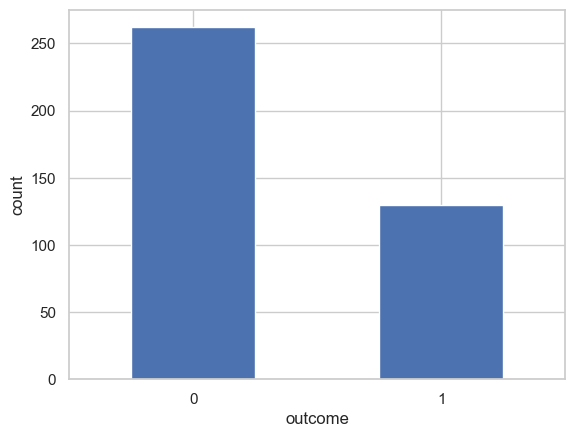

In [21]:
diabetes_df['outcome'].value_counts().plot(kind='bar', xlabel='outcome', ylabel='count', rot=0)

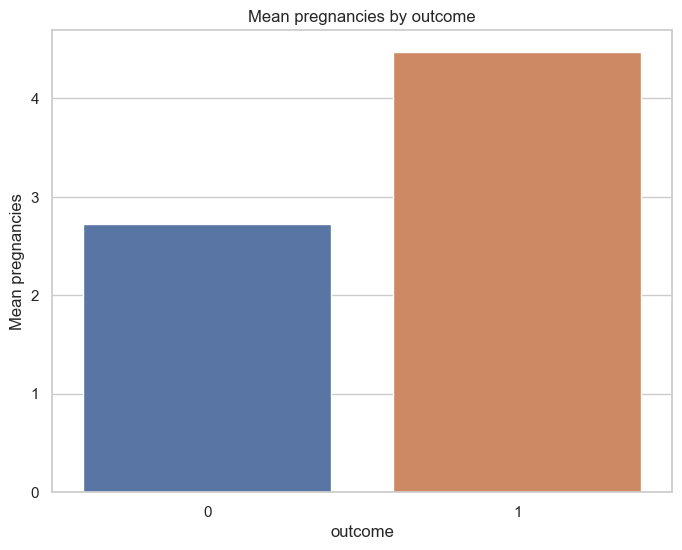

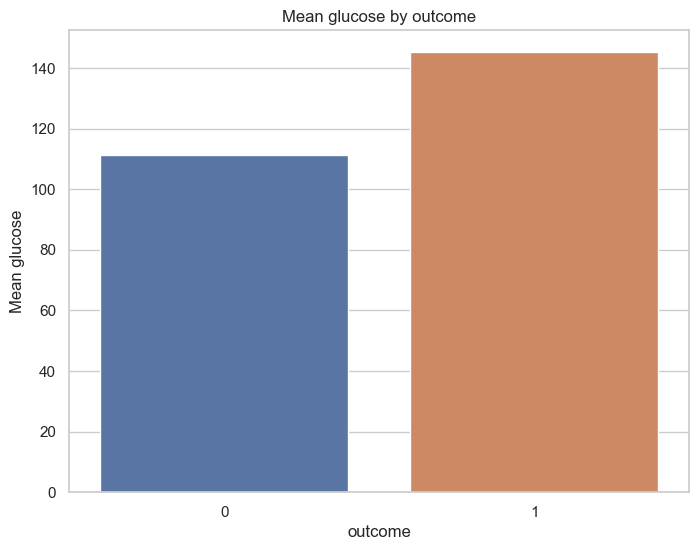

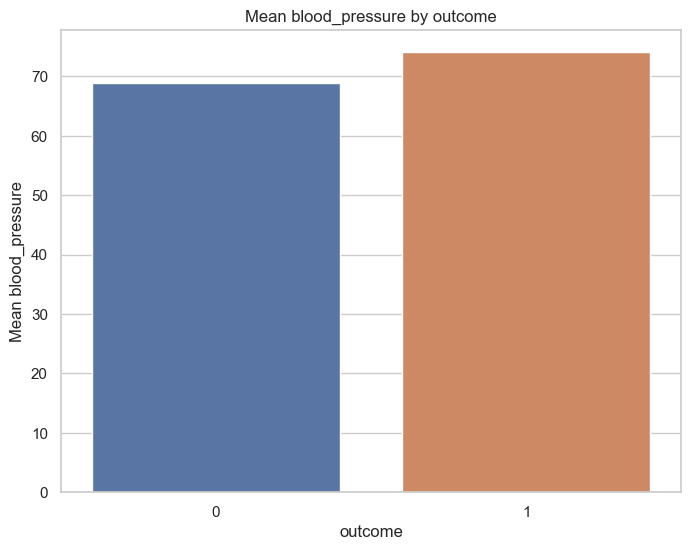

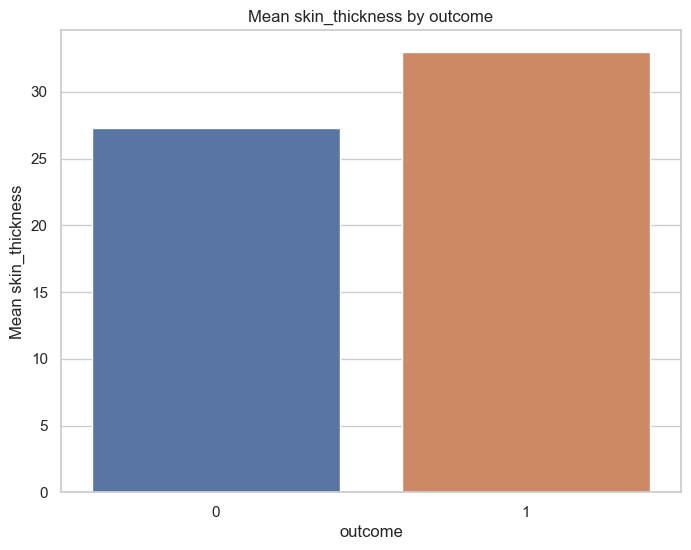

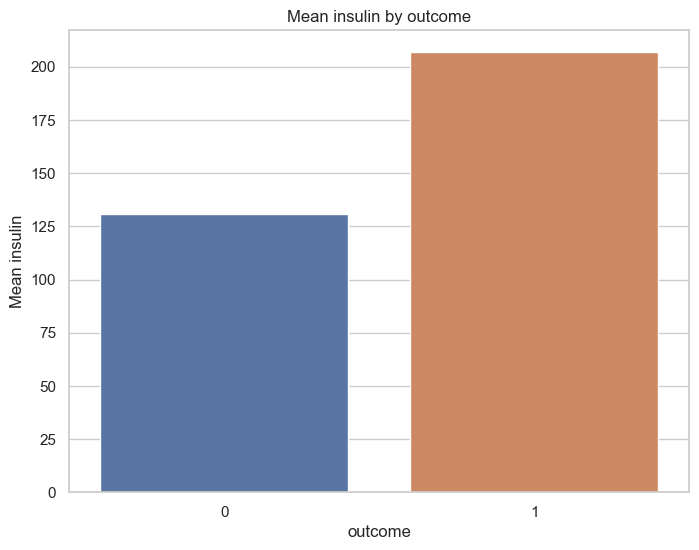

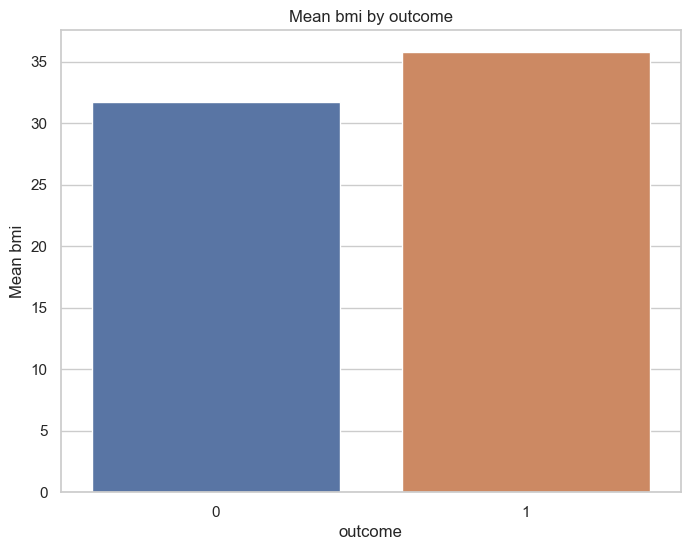

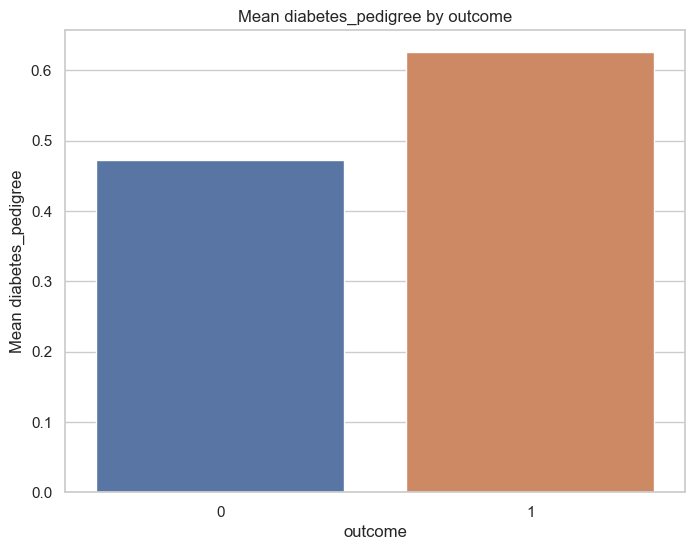

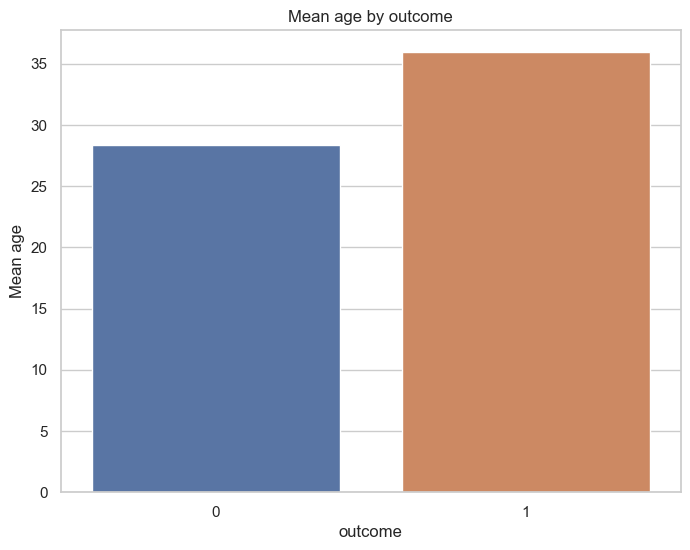

In [22]:
list_of_columns = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree', 'age']

target_var = diabetes_df.groupby('outcome').count()
num_cols = list_of_columns

def generate_grouped_bar_plots(data, target_var):
    
    for col in num_cols:
        plt.figure(figsize=(8, 6))
        grouped_data = diabetes_df.groupby(target_var)[col].mean().reset_index()
        sns.barplot(x=target_var, y=col, data=grouped_data)
        plt.xlabel(target_var)
        plt.ylabel(f'Mean {col}')
        plt.title(f'Mean {col} by {target_var}')
        plt.show()

generate_grouped_bar_plots(diabetes_df, 'outcome')

The target variable is inbalanced.

In [23]:
outcomes = diabetes_df["outcome"].unique()
grouped_df = diabetes_df.groupby("outcome")
for var in ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree', 'age']:
    print("------------------------------------------------")
    print("Comparisons for variable: {}".format(var))
    print("------------------------------------------------")
    for i in range(0, len(outcomes)):
        for j in range(i+1, len(outcomes)):
            print("t-test between groups {0} and {1}:".format(outcomes[i], outcomes[j]))
            print(stats.ttest_ind(
                diabetes_df[diabetes_df["outcome"]==outcomes[i]][var], 
                diabetes_df[diabetes_df["outcome"]==outcomes[j]][var]
            ))

------------------------------------------------
Comparisons for variable: pregnancies
------------------------------------------------
t-test between groups 0 and 1:
Ttest_indResult(statistic=-5.242246822948837, pvalue=2.6051267615668623e-07)
------------------------------------------------
Comparisons for variable: glucose
------------------------------------------------
t-test between groups 0 and 1:
Ttest_indResult(statistic=-11.886902756072889, pvalue=5.096874741445402e-28)
------------------------------------------------
Comparisons for variable: blood_pressure
------------------------------------------------
t-test between groups 0 and 1:
Ttest_indResult(statistic=-3.8776478026014862, pvalue=0.00012374786935027577)
------------------------------------------------
Comparisons for variable: skin_thickness
------------------------------------------------
t-test between groups 0 and 1:
Ttest_indResult(statistic=-5.228464463533362, pvalue=2.7932197351253005e-07)
---------------------

The t-test indicates that all indicators are statistically significant. 

I will apply PCA and because variables show a significant difference in magnitude I'll apply standardizationas well.

In [26]:
X = diabetes_df[['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree', 'age']
]

X = StandardScaler().fit_transform(X)

sklearn_pca = PCA(n_components=3)
diabetes_df['pca_1'] = sklearn_pca.fit_transform(X)

print(
     'The percentage of total variance in the dataset explained by each component',
      sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component [0.31994031 0.19459756 0.14984544]


In [27]:
diabetes_df[['outcome', 'pca_1', 'pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree', 'age']
].corr()

,outcome,pca_1,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age
outcome,1.000000,0.531153,0.256566,0.515703,0.192673,0.255936,0.301429,0.270118,0.209330,0.350804
pca_1,0.531153,1.000000,0.503297,0.678867,0.527274,0.612500,0.583763,0.588348,0.267768,0.658442
pregnancies,0.256566,0.503297,1.000000,0.198291,0.213355,0.093209,0.078984,-0.025347,0.007562,0.679608
glucose,0.515703,0.678867,0.198291,1.000000,0.210027,0.198856,0.581223,0.209516,0.140180,0.343641
blood_pressure,0.192673,0.527274,0.213355,0.210027,1.000000,0.232571,0.098512,0.304403,-0.015971,0.300039
skin_thickness,0.255936,0.612500,0.093209,0.198856,0.232571,1.000000,0.182199,0.664355,0.160499,0.167761
insulin,0.301429,0.583763,0.078984,0.581223,0.098512,0.182199,1.000000,0.226397,0.135906,0.217082
bmi,0.270118,0.588348,-0.025347,0.209516,0.304403,0.664355,0.226397,1.000000,0.158771,0.069814
diabetes_pedigree,0.209330,0.267768,0.007562,0.140180,-0.015971,0.160499,0.135906,0.158771,1.000000,0.085029
age,0.350804,0.658442,0.679608,0.343641,0.300039,0.167761,0.217082,0.069814,0.085029,1.000000


The pca_1 compenent would be the best for my model. It has a mid corr value yet is the strongest of all variables.

# Summary

## Dataset (Pima Indians Diabetes)

    * The dataset contains the following:
        1. 763 observations and 9 columns
        2. No duplicate entries were found
        3. 0 value entries were dropped due to reasonable assumuption that such values could not be had for biological data. Such as 0 for blood pressure.
        4. The resulting set contained 392 observations
        5. There are 8 predictors and 1 target variable
            * Predictors - pregnancies, glucose, bllod pressure, skin thickness, insulin, bmi, diabetes pedigree, age
            * Target - outcome (0-no, 1-yes)
        6. Outliers were determined to not be of statistical significance compared to the possiblity of data bias.
        
### Data Exploration

1. All predictors had a positive correelation with the outcome variable.
2. The age variable was the only one that had a univariate correlation (0.25 or greater) with 3 other predictors.
    * glucose, blood pressure, pregnancies
3. The target variable was unbalanced showing a statistically greater number of 0-no results.
4. There are no high level correlation variables with the outcome.
5. There was one mid-level correlation variable to the outcome.
    * glucose (0.52)

### Feature Engineering

A PCA analysis was performed. The result of which demonstrated that the use of the first principal component may be the best variable choice for my model. The correlation with the outcome was 0.53 which is slightly higher than the highest biological variable of glucose at 0.52. Because all the biological variables are not highly correlated with each other and the PCA result is within target I believe it would perform well in this case.